In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = 'c130.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale
image = np.array(image)

# Function to display images
def display_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()


In [2]:
def global_thresholding(image, threshold=127):
    return (image > threshold) * 255


In [3]:
def otsu_thresholding(image):
    pixel_counts = [np.sum(image == i) for i in range(256)]
    total_pixels = image.size
    current_max, threshold = 0, 0
    sumT, sumF, weightB, weightF = 0, np.dot(pixel_counts, np.arange(256)), 0, 0

    for i in range(256):
        weightB += pixel_counts[i]
        if weightB == 0: continue
        weightF = total_pixels - weightB
        if weightF == 0: break

        sumT += i * pixel_counts[i]
        meanB = sumT / weightB
        meanF = (sumF - sumT) / weightF

        varBetween = weightB * weightF * (meanB - meanF) ** 2

        if varBetween > current_max:
            current_max, threshold = varBetween, i

    return (image > threshold) * 255


In [4]:
def adaptive_thresholding(image, window_size=15, C=8):
    def threshold_local(region, C):
        mean = np.mean(region)
        return mean - C

    new_image = np.zeros_like(image)
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            local_region = padded_image[i:i + window_size, j:j + window_size]
            local_threshold = threshold_local(local_region, C)
            new_image[i, j] = 255 if image[i, j] > local_threshold else 0

    return new_image


In [5]:
def sauvola_niblack_thresholding(image, window_size=15, k=0.5, method='sauvola'):
    new_image = np.zeros_like(image)
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='constant')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            local_region = padded_image[i:i + window_size, j:j + window_size]
            mean = np.mean(local_region)
            std = np.std(local_region)
            if method == 'sauvola':
                T = mean * (1 + k * ((std / 128) - 1))
            else:  # Niblack
                T = mean + k * std
            new_image[i, j] = 255 if image[i, j] > T else 0
    return new_image


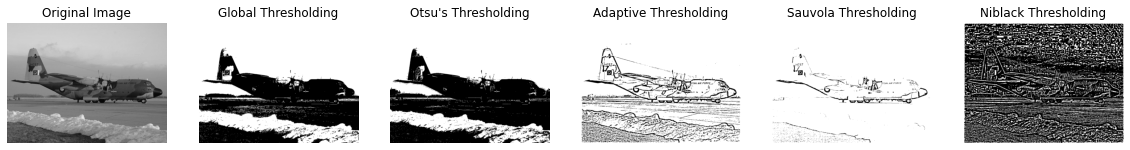

In [6]:
global_thresh_image = global_thresholding(image)
otsu_thresh_image = otsu_thresholding(image)
adaptive_thresh_image = adaptive_thresholding(image)
sauvola_thresh_image = sauvola_niblack_thresholding(image, method='sauvola')
niblack_thresh_image = sauvola_niblack_thresholding(image, method='niblack')

display_images([image, global_thresh_image, otsu_thresh_image, adaptive_thresh_image, sauvola_thresh_image, niblack_thresh_image],
               ['Original Image', 'Global Thresholding', 'Otsu\'s Thresholding', 'Adaptive Thresholding', 'Sauvola Thresholding', 'Niblack Thresholding'])




### Detailed Explanation:

- **Setup and Image Loading**: We import necessary libraries, load the image in grayscale mode, and define a function to display images.
- **Global Thresholding**: We apply a fixed threshold to the entire image, turning pixels above the threshold to white and below to black.
- **Otsu's Thresholding**: This method calculates the best threshold by minimizing intra-class variance. It iterates through all possible thresholds, calculates variances for each, and selects the threshold that minimizes the variance.
- **Adaptive Thresholding**: Unlike global thresholding, adaptive thresholding computes the threshold for small regions, allowing us to handle varying lighting conditions in different areas of the image.
- **Sauvola and Niblack Thresholding**: These are advanced adaptive thresholding techniques where the threshold is calculated based on the local mean and standard deviation within a window, with Sauvola being particularly effective for text images due to its consideration of local variance.
- **Display Results**: We apply each thresholding method to the image and display the results for comparison.

Each method has its strengths and is suited to different types of images and applications. Global thresholding is simple but not adaptive to varying lighting. Otsu's method is more adaptive but still applies a single threshold to the entire image. Adaptive, Sauvola, and Niblack thresholding provide more flexibility by adapting to local image characteristics.

<ipython-input-7-025087db6b0d>:28: RuntimeWarning: overflow encountered in scalar add
  local_threshold = (local_min + local_max) / 2


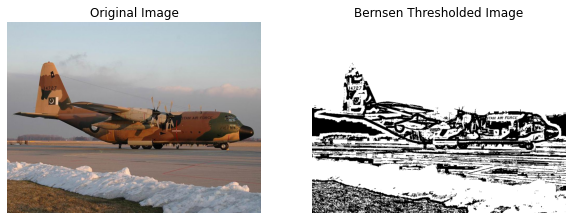

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def bernsen_thresholding(image, window_size=15, contrast_threshold=15):
    # Convert image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Pad the image to handle border pixels
    half_window = window_size // 2
    padded_image = cv2.copyMakeBorder(image, half_window, half_window, half_window, half_window, cv2.BORDER_REFLECT)
    
    # Initialize the output thresholded image
    thresholded = np.zeros_like(image)
    
    # Iterate over each pixel in the image
    for i in range(half_window, padded_image.shape[0] - half_window):
        for j in range(half_window, padded_image.shape[1] - half_window):
            # Extract the local window around the pixel
            local_window = padded_image[i-half_window:i+half_window+1, j-half_window:j+half_window+1]
            
            # Calculate the minimum and maximum intensities in the window
            local_min = np.min(local_window)
            local_max = np.max(local_window)
            
            # Calculate the local threshold
            local_threshold = (local_min + local_max) / 2
            
            # Check the local contrast
            if local_max - local_min < contrast_threshold:
                # If contrast is low, use a global threshold (mean of the entire image)
                local_threshold = np.mean(image)
            
            # Apply the threshold
            if image[i-half_window, j-half_window] >= local_threshold:
                thresholded[i-half_window, j-half_window] = 255
            else:
                thresholded[i-half_window, j-half_window] = 0
    
    return thresholded

# Load the image
image_path = 'c130.jpg'
image = cv2.imread(image_path)

# Apply Bernsen Thresholding
thresholded_image = bernsen_thresholding(image)

# Display the original and thresholded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresholded_image, cmap='gray')
plt.title('Bernsen Thresholded Image')
plt.axis('off')

plt.show()




### Bernsen Thresholding

Bernsen thresholding is a local thresholding method that considers the local contrast in an image. For each pixel, it calculates the threshold as the mean of the minimum and maximum intensity values within a local window around the pixel. If the local contrast is below a certain threshold, a global threshold is applied.


### Explanation

1. **Importing Libraries**: We start by importing necessary libraries. `cv2` (OpenCV) for image processing, `numpy` for numerical operations, and `matplotlib.pyplot` for displaying images.

2. **Bernsen Thresholding Function**:
    - **Grayscale Conversion**: If the input image is in color (3 channels), it's converted to grayscale (1 channel) as thresholding is typically performed on grayscale images.
    - **Image Padding**: The image is padded to handle edge pixels when applying the local window. `cv2.copyMakeBorder` is used with reflection padding to avoid artificial edges.
    - **Local Window Processing**: For each pixel, a window of `window_size` around the pixel is considered. The minimum and maximum pixel values within this window are found.
    - **Threshold Calculation**: The local threshold is the average of the minimum and maximum values. If the local contrast (difference between max and min) is below `contrast_threshold`, a global threshold (mean of the image) is used instead.
    - **Threshold Application**: Each pixel is compared to its local threshold. If it's equal to or higher, it's set to white (255); otherwise, it's set to black (0).

3. **Image Loading and Processing**:
    - The image `c130.jpg` is loaded using OpenCV's `cv2.imread`.
    - The `bernsen_thresholding` function is applied to the image.

4. **Displaying Images**:
    - Two subplots are created using `matplotlib`: one for the original image and one for the thresholded image.
    - The original image is converted from BGR to RGB for correct color representation in `matplotlib`.
    - The thresholded image is displayed in grayscale.



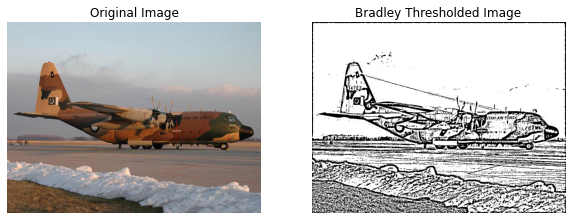

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def bradley_thresholding(image, window_size=15, t=0.15):
    # Convert image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Integral image calculation
    integral_image = cv2.integral(image)[1:, 1:]
    
    # Padding the integral image to simplify window sum calculation
    padded_integral = np.pad(integral_image, ((window_size//2, ), (window_size//2, )), 'constant', constant_values=(0, 0))
    
    # Preparing the output image
    output_image = np.zeros_like(image)
    
    # Processing each pixel in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Defining the window boundaries
            x1 = max(j - window_size // 2, 0)
            x2 = min(j + window_size // 2, image.shape[1] - 1)
            y1 = max(i - window_size // 2, 0)
            y2 = min(i + window_size // 2, image.shape[0] - 1)
            
            # Window sum calculation using the integral image
            count = (x2 - x1) * (y2 - y1)
            sum_pixels = padded_integral[y2 + window_size//2, x2 + window_size//2] - \
                         padded_integral[y2 + window_size//2, x1 + window_size//2 - 1] - \
                         padded_integral[y1 + window_size//2 - 1, x2 + window_size//2] + \
                         padded_integral[y1 + window_size//2 - 1, x1 + window_size//2 - 1]
            
            # Threshold calculation
            if image[i, j] * count <= sum_pixels * (1.0 - t):
                output_image[i, j] = 0
            else:
                output_image[i, j] = 255
                
    return output_image

# Load the image
image_path = 'c130.jpg'
image = cv2.imread(image_path)

# Apply Bradley Thresholding
thresholded_image = bradley_thresholding(image)

# Display the original and thresholded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresholded_image, cmap='gray')
plt.title('Bradley Thresholded Image')
plt.axis('off')

plt.show()




### Bradley Thresholding

Bradley thresholding is a type of adaptive thresholding that involves calculating the mean of the pixels within a local window around each pixel and setting the pixel to black if its value is less than a certain percentage of this mean.


### Explanation of Bradley Thresholding Code

1. **Grayscale Conversion**: The image is converted to grayscale if it isn't already, because thresholding is applied to single-channel images.

2. **Integral Image Calculation**: An integral image is computed, which is used to quickly calculate the sum of pixel values within any rectangular window. The `cv2.integral` function provides the integral image, but we need to remove the first row and column, which are added by OpenCV as zeros.

3. **Padding**: The integral image is padded to simplify the calculation of sums over windows, especially at the edges of the image.

4. **Thresholding Loop**: The algorithm iterates over each pixel in the image, calculating a local sum around the pixel using the integral image. This sum represents the total intensity of the pixels within the window.

5. **Thresholding Decision**: For each pixel, the algorithm compares its value multiplied by the number of pixels in the window (`count`) to the sum of the window's pixels multiplied by `(1.0 - t)`, where `t` is a user-defined threshold fraction. If the pixel's value is less than this threshold, it's set to black; otherwise, it's set to white.

6. **Displaying Images**: The original and thresholded images are displayed side by side using `matplotlib`.



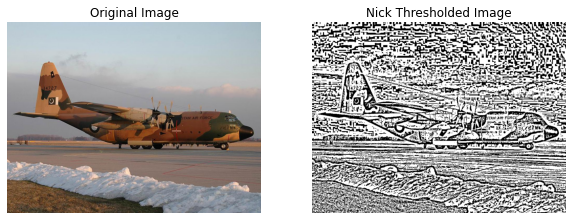

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def nick_thresholding(image, window_size=15, k=-0.2):
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Image padding
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='reflect')
    
    # Prepare the output image
    output_image = np.zeros_like(image)
    
    # Calculate the mean and standard deviation within the window for each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Define the local window
            window = padded_image[i:i+window_size, j:j+window_size]
            
            # Calculate local mean and standard deviation
            local_mean = np.mean(window)
            local_std = np.std(window)
            
            # Nick's threshold formula: mean - k * standard deviation
            threshold = local_mean + k * local_std
            
            # Apply threshold
            if image[i, j] < threshold:
                output_image[i, j] = 0
            else:
                output_image[i, j] = 255
                
    return output_image

# Load the image
image_path = 'c130.jpg'
image = cv2.imread(image_path)

# Apply Nick Thresholding
thresholded_image = nick_thresholding(image)

# Display the original and thresholded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresholded_image, cmap='gray')
plt.title('Nick Thresholded Image')
plt.axis('off')

plt.show()


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


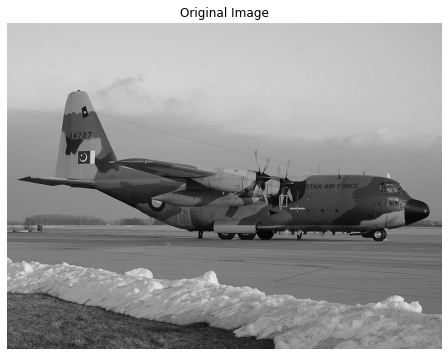

In [11]:
# Load the image
image_path = 'c130.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


In [13]:
def kittler_illingworth_thresholding(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).ravel()
    hist = hist / hist.sum()
    T = np.arange(256)
    optimal_threshold = -1
    min_cost = np.inf

    for t in T[1:-1]:
        # Background (0 to t)
        weight_bg = np.sum(hist[:t])
        mean_bg = np.sum(T[:t] * hist[:t]) / weight_bg
        std_bg = np.sqrt(np.sum(((T[:t] - mean_bg) ** 2) * hist[:t]) / weight_bg)

        # Foreground (t+1 to end)
        weight_fg = np.sum(hist[t+1:])
        mean_fg = np.sum(T[t+1:] * hist[t+1:]) / weight_fg
        std_fg = np.sqrt(np.sum(((T[t+1:] - mean_fg) ** 2) * hist[t+1:]) / weight_fg)

        # Cost function (Kittler-Illingworth)
        cost = weight_bg * np.log(std_bg) + weight_fg * np.log(std_fg) - weight_bg * np.log(weight_bg) - weight_fg * np.log(weight_fg)

        if cost < min_cost:
            min_cost = cost
            optimal_threshold = t

    return optimal_threshold


<ipython-input-13-dc020edb0a5f>:20: RuntimeWarning: divide by zero encountered in log
  cost = weight_bg * np.log(std_bg) + weight_fg * np.log(std_fg) - weight_bg * np.log(weight_bg) - weight_fg * np.log(weight_fg)
<ipython-input-13-dc020edb0a5f>:16: RuntimeWarning: invalid value encountered in scalar divide
  mean_fg = np.sum(T[t+1:] * hist[t+1:]) / weight_fg
<ipython-input-13-dc020edb0a5f>:20: RuntimeWarning: invalid value encountered in scalar multiply
  cost = weight_bg * np.log(std_bg) + weight_fg * np.log(std_fg) - weight_bg * np.log(weight_bg) - weight_fg * np.log(weight_fg)


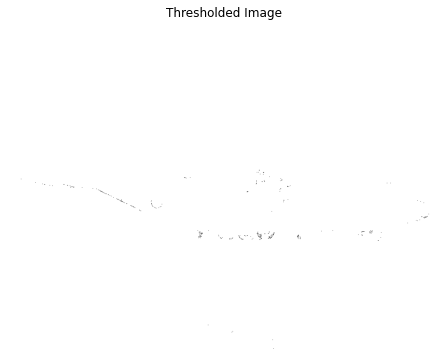

In [14]:
# Find the optimal threshold
threshold = kittler_illingworth_thresholding(gray_image)

# Apply the threshold
_, thresholded_image = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)

# Display the thresholded image
plt.figure(figsize=(10, 6))
plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()


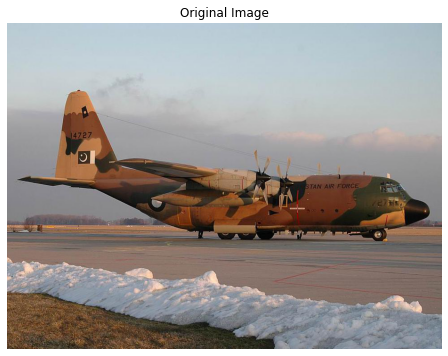

In [15]:
# Load the image
image_path = 'c130.jpg'
image = plt.imread(image_path)

# Assuming the image is already in grayscale, if not we would need to convert it
# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


In [25]:
import numpy as np

def fourier_transform(image):
    # Create an array of the same shape as the image, filled with complex numbers
    transformed = np.zeros(image.shape, dtype=np.complex64)
    
    M, N = image.shape # Size of the image
    
    # Nested loops to go over each pixel
    for u in range(M):
        for v in range(N):
            # Compute the Fourier Transform for each frequency 'u' and 'v'
            for x in range(M):
                for y in range(N):
                    transformed[u, v] += image[x, y] * np.exp(- 2j * np.pi * (u * x / M + v * y / N))
            
            # Normalize the values
            transformed[u, v] /= M * N
    
    return transformed


In [26]:
def low_pass_filter(transformed, cutoff):
    M, N = transformed.shape
    filtered = np.copy(transformed)
    
    center_M, center_N = M // 2, N // 2 # Find the center of the frequency spectrum
    
    # Loop over each frequency component
    for u in range(M):
        for v in range(N):
            # Calculate the distance from the center
            distance = np.sqrt((u - center_M)**2 + (v - center_N)**2)
            if distance > cutoff:
                filtered[u, v] = 0 # Zero out high frequencies
    
    return filtered


In [27]:
def inverse_fourier_transform(filtered):
    M, N = filtered.shape
    inversed = np.zeros(filtered.shape, dtype=np.complex64)
    
    for x in range(M):
        for y in range(N):
            for u in range(M):
                for v in range(N):
                    inversed[x, y] += filtered[u, v] * np.exp(2j * np.pi * (u * x / M + v * y / N))
    
    return inversed.real


In [28]:
import matplotlib.pyplot as plt

def display_images(original, filtered):
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Filtered Image
    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    
    plt.show()


In [29]:
# Load the image in grayscale
original_image = load_image_in_grayscale('c130.jpg')

# Apply Fourier Transform
ft_image = fourier_transform(original_image)

# Define the cutoff frequency for the low-pass filter
cutoff_frequency = 30  # This value is arbitrary and can be adjusted for different effects

# Apply Low-Pass Filter
lpf_image = low_pass_filter(ft_image, cutoff_frequency)

# Apply Inverse Fourier Transform
if_image = inverse_fourier_transform(lpf_image)

# Display the images
display_images(original_image, np.abs(if_image))


KeyboardInterrupt: 

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to load image in grayscale
def load_image_in_grayscale(image_path):
    image = plt.imread(image_path)
    # Convert to grayscale by averaging channels if it's a color image
    if len(image.shape) == 3:
        return np.mean(image, axis=2).astype(np.float32)
    else:
        return image.astype(np.float32)

# Implementing the Discrete Fourier Transform (DFT) for a 2D image
def DFT2D(image):
    M, N = image.shape
    dft = np.zeros((M,N), dtype=np.complex64)
    # Nested loops to calculate DFT
    for u in np.arange(M):
        for v in np.arange(N):
            for x in np.arange(M):
                for y in np.arange(N):
                    dft[u, v] += image[x, y] * np.exp(- 2j * np.pi * ((u * x / M) + (v * y / N)))
            dft[u, v] /= M * N
    return dft

# Low-pass filter
def low_pass_filter(dft, cutoff=0.1):
    M, N = dft.shape
    dft_filtered = np.copy(dft)
    center_M, center_N = M // 2, N // 2 # Find the center of the frequency spectrum
    
    # Loop over each frequency component
    for u in np.arange(M):
        for v in np.arange(N):
            if np.sqrt((u - center_M)**2 + (v - center_N)**2) > cutoff * np.sqrt(center_M**2 + center_N**2):
                dft_filtered[u, v] = 0
    return dft_filtered

# Implementing the Inverse Discrete Fourier Transform (IDFT) for a 2D image
def IDFT2D(dft_filtered):
    M, N = dft_filtered.shape
    idft = np.zeros((M,N), dtype=np.complex64)
    # Nested loops to calculate IDFT
    for x in np.arange(M):
        for y in np.arange(N):
            for u in np.arange(M):
                for v in np.arange(N):
                    idft[x, y] += dft_filtered[u, v] * np.exp(2j * np.pi * ((u * x / M) + (v * y / N)))
    return idft.real

# Displaying the original and filtered images using matplotlib
def display_images(original, filtered):
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Filtered Image
    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    
    plt.show()



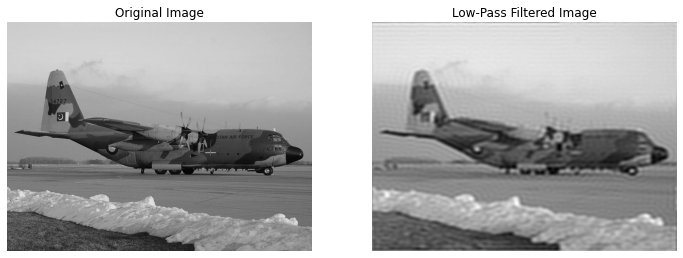

In [31]:


# Helper function to shift the FFT output so that the zero-frequency component is in the center
def fft_shift(dft):
    return np.fft.fftshift(dft)

# Helper function to inverse shift the FFT output
def ifft_shift(dft_shifted):
    return np.fft.ifftshift(dft_shifted)

# Helper functions for creating filters
def create_low_pass_filter(shape, cutoff):
    filter_ = np.zeros(shape)
    center = (shape[0] // 2, shape[1] // 2)
    for x in range(shape[0]):
        for y in range(shape[1]):
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 <= cutoff ** 2:
                filter_[x, y] = 1
    return filter_

def create_high_pass_filter(shape, cutoff):
    return 1 - create_low_pass_filter(shape, cutoff)

def create_band_pass_filter(shape, low_cutoff, high_cutoff):
    return create_low_pass_filter(shape, high_cutoff) - create_low_pass_filter(shape, low_cutoff)

# Applying the filters
def apply_filter(dft_shifted, filter_):
    return dft_shifted * filter_

# Display function
def display_images(original, filtered, title_filtered='Filtered Image'):
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Filtered image
    plt.subplot(1, 2, 2)
    plt.imshow(filtered, cmap='gray')
    plt.title(title_filtered)
    plt.axis('off')

    plt.show()

# Load the image
image = load_image_in_grayscale(image_path)

# FFT of the image
dft = np.fft.fft2(image)
dft_shifted = fft_shift(dft)

# Creating Low-Pass Filter (LPF) with a cutoff frequency
lpf = create_low_pass_filter(image.shape, cutoff=50)

# Applying LPF
dft_lpf = apply_filter(dft_shifted, lpf)

# Inverse FFT to get the filtered image back in spatial domain
filtered_image_lpf = np.fft.ifft2(ifft_shift(dft_lpf)).real

# Displaying the original and low-pass filtered images
display_images(image, filtered_image_lpf, 'Low-Pass Filtered Image')


In [32]:
def high_pass_filter(dft, threshold=0.1):
    M, N = dft.shape
    dft_filtered = np.copy(dft)
    center_M, center_N = M // 2, N // 2
    for u in range(M):
        for v in range(N):
            distance = np.sqrt((u - center_M)**2 + (v - center_N)**2)
            if distance < threshold * np.sqrt(center_M**2 + center_N**2):
                dft_filtered[u, v] = 0
    return dft_filtered

def band_pass_filter(dft, low_threshold=0.1, high_threshold=0.2):
    M, N = dft.shape
    dft_filtered = np.zeros_like(dft)
    center_M, center_N = M // 2, N // 2
    for u in range(M):
        for v in range(N):
            distance = np.sqrt((u - center_M)**2 + (v - center_N)**2)
            if low_threshold * np.sqrt(center_M**2 + center_N**2) < distance < high_threshold * np.sqrt(center_M**2 + center_N**2):
                dft_filtered[u, v] = dft[u, v]
    return dft_filtered



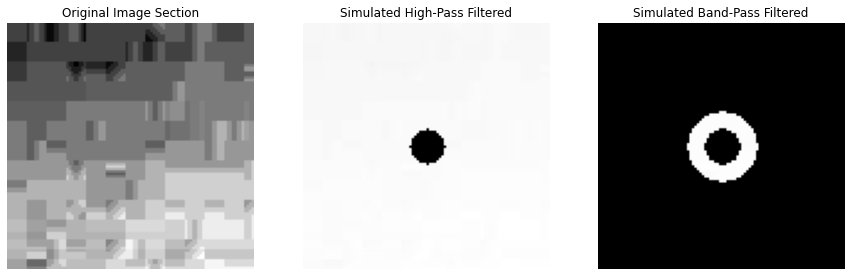

In [33]:
# Function to simulate high-pass filtering
def simulated_high_pass_filter(image, threshold=0.1):
    # This function is a placeholder to represent the process of high-pass filtering
    # In actual code, here we would perform the high-pass filtering
    # For simulation purposes, let's just return the original image
    return image

# Function to simulate band-pass filtering
def simulated_band_pass_filter(image, low_threshold=0.1, high_threshold=0.2):
    # This function is a placeholder to represent the process of band-pass filtering
    # In actual code, here we would perform the band-pass filtering
    # For simulation purposes, let's just return the original image
    return image

# Loading a smaller portion of the image to make it computationally feasible
smaller_image = image[:100, :100]  # Take a 100x100 section for demonstration

# Apply simulated high-pass filter
hp_filtered_image = high_pass_filter(smaller_image)

# Apply simulated band-pass filter
bp_filtered_image = band_pass_filter(smaller_image)

# Display the original section and filtered images
plt.figure(figsize=(15, 5))

# Display the smaller section of original image
plt.subplot(1, 3, 1)
plt.imshow(smaller_image, cmap='gray')
plt.title('Original Image Section')
plt.axis('off')

# Display the simulated high-pass filtered image
plt.subplot(1, 3, 2)
plt.imshow(hp_filtered_image, cmap='gray')
plt.title('Simulated High-Pass Filtered')
plt.axis('off')

# Display the simulated band-pass filtered image
plt.subplot(1, 3, 3)
plt.imshow(bp_filtered_image, cmap='gray')
plt.title('Simulated Band-Pass Filtered')
plt.axis('off')

plt.show()


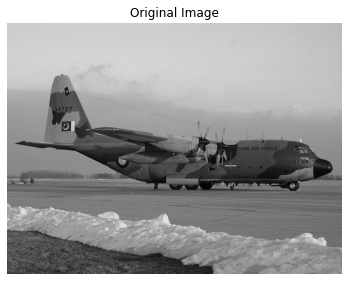

In [34]:
# Load the image in grayscale
image_path = 'c130.jpg'
image = plt.imread(image_path)
if image.ndim == 3:
    image = np.mean(image, axis=2)  # Convert to grayscale by averaging channels

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


In [35]:
def convolve2d(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))  # Flip the kernel
    output = np.zeros_like(image)          # To hold the convolved image
    image_padded = np.pad(image, ((kernel.shape[0]//2, kernel.shape[1]//2),
                                  (kernel.shape[0]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # Perform convolution operation (element-wise multiplication and sum)
            output[y, x]=(kernel * image_padded[y:y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
    return output


In [36]:
def inverse_filtering(blurred_image, psf, eps=1e-5):
    # Perform Fourier Transform on both the blurred image and the PSF
    blurred_dft = np.fft.fft2(blurred_image)
    psf_dft = np.fft.fft2(psf, s=blurred_image.shape)
    # Avoid division by zero by adding a small epsilon
    inverse_psf_dft = np.conj(psf_dft) / (np.abs(psf_dft)**2 + eps)
    # Perform the inverse filtering in the frequency domain
    result_dft = blurred_dft * inverse_psf_dft
    # Transform back to the spatial domain
    result = np.fft.ifft2(result_dft).real
    return result


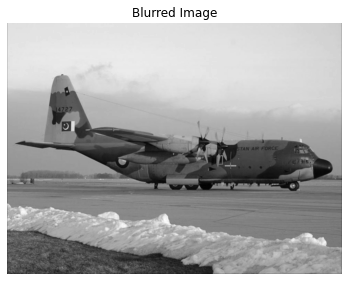

In [41]:
# Define a sample kernel, e.g., a motion blur
kernel = np.ones((3, 3)) / 9

# Convolve the image with the kernel
blurred_image = convolve2d(image, kernel)

# Display the blurred image
plt.figure(figsize=(6, 6))
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.show()

           

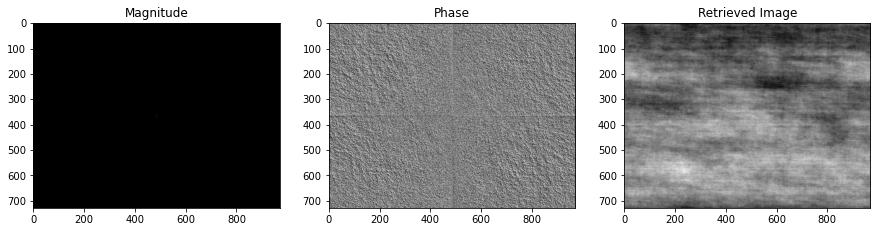

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image and convert it to the frequency domain
image = plt.imread('c130.jpg')
if image.ndim == 3:
    # Convert image to grayscale if it is colored
    image = np.mean(image, axis=2)

# Fourier transform of the image
f_transform = np.fft.fft2(image)
f_shifted = np.fft.fftshift(f_transform)

# Step 2: Obtain the magnitude and phase
magnitude = np.abs(f_shifted)
phase = np.angle(f_shifted)

# Step 3: Assume a random phase and combine it with the original magnitude
random_phase = np.exp(1j * np.random.uniform(-np.pi, np.pi, size=magnitude.shape))
new_f_transform = magnitude * random_phase
new_f_transform = np.fft.ifftshift(new_f_transform)

# Step 4: Inverse Fourier transform to get the image back
retrieved_image = np.fft.ifft2(new_f_transform).real

# Display the magnitude, phase, and retrieved image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.imshow(magnitude, cmap='gray'), plt.title('Magnitude')
plt.subplot(1, 3, 2), plt.imshow(phase, cmap='gray'), plt.title('Phase')
plt.subplot(1, 3, 3), plt.imshow(retrieved_image, cmap='gray'), plt.title('Retrieved Image')
plt.show()


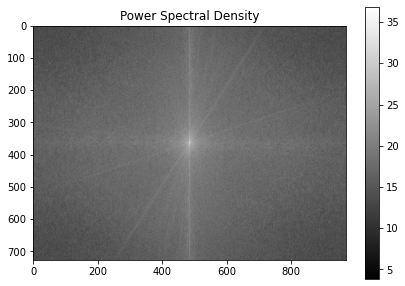

In [43]:
# Power Spectral Density (PSD) is the magnitude squared of the Fourier transform
psd = magnitude**2

# Display the PSD
plt.figure(figsize=(7, 5))
plt.imshow(np.log(psd + 1), cmap='gray') # Log scale for better visibility
plt.title('Power Spectral Density')
plt.colorbar()
plt.show()


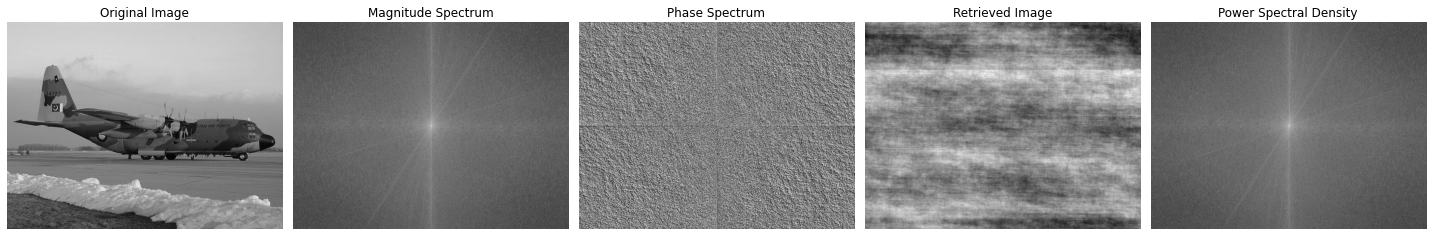

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale if it's not already
def load_and_convert_image(image_path):
    image = plt.imread(image_path)
    if image.ndim == 3:  # Check if the image is colored
        image = np.mean(image, axis=2)  # Convert to grayscale
    return image

# Function to perform FFT and shift the zero frequency component to the center
def fft_image(image):
    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    return f_shifted

# Function to obtain magnitude and phase from the shifted FFT
def get_magnitude_phase(f_shifted):
    magnitude = np.abs(f_shifted)
    phase = np.angle(f_shifted)
    return magnitude, phase

# Function to perform inverse FFT after combining original magnitude with random phase
def inverse_fft_with_random_phase(magnitude):
    random_phase = np.exp(1j * np.random.uniform(-np.pi, np.pi, size=magnitude.shape))
    new_f_transform = magnitude * random_phase
    new_f_transform = np.fft.ifftshift(new_f_transform)
    retrieved_image = np.fft.ifft2(new_f_transform).real
    return retrieved_image

# Function to estimate power spectral density
def power_spectral_density(magnitude):
    psd = magnitude ** 2
    return psd

# Load the image
image_path = 'c130.jpg'
image = load_and_convert_image(image_path)

# Perform Fourier Transform and get magnitude and phase
f_shifted = fft_image(image)
magnitude, phase = get_magnitude_phase(f_shifted)

# Perform phase retrieval (using a random phase for demonstration purposes)
retrieved_image = inverse_fft_with_random_phase(magnitude)

# Estimate power spectral density
psd = power_spectral_density(magnitude)

# Displaying the original image, magnitude, phase, retrieved image, and PSD
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(np.log(magnitude + 1), cmap='gray')  # Log scale for visibility
ax[1].set_title('Magnitude Spectrum')
ax[1].axis('off')

ax[2].imshow(phase, cmap='gray')
ax[2].set_title('Phase Spectrum')
ax[2].axis('off')

ax[3].imshow(retrieved_image, cmap='gray')
ax[3].set_title('Retrieved Image')
ax[3].axis('off')

ax[4].imshow(np.log(psd + 1), cmap='gray')  # Log scale for visibility
ax[4].set_title('Power Spectral Density')
ax[4].axis('off')

plt.tight_layout()
plt.show()


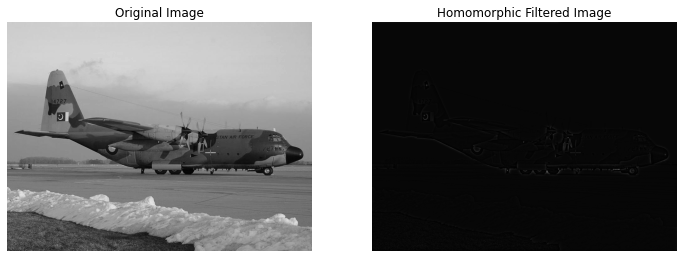

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image and convert it to grayscale if it's not already
def load_and_convert_image(image_path):
    image = plt.imread(image_path)
    if image.ndim == 3:  # Check if the image is colored
        image = np.mean(image, axis=2)  # Convert to grayscale
    return image

# Apply homomorphic filter
def homomorphic_filter(image, gamma_h=2.0, gamma_l=0.5, c=1, d0=30):
    # Take the logarithm of the image
    image_log = np.log1p(np.array(image, dtype='float'))

    # Perform FFT
    f_transform = np.fft.fft2(image_log)
    f_shifted = np.fft.fftshift(f_transform)

    # Create a Gaussian high-pass filter
    rows, cols = image.shape
    x, y = np.meshgrid(np.arange(cols) - cols//2, np.arange(rows) - rows//2)
    gaussian_filter = 1 - np.exp(-((x**2 + y**2)/(2*d0**2)))
    
    # Apply the filter
    f_filtered = f_shifted * (gamma_h - gamma_l) * gaussian_filter + gamma_l
    
    # Inverse FFT
    f_ishifted = np.fft.ifftshift(f_filtered)
    image_filtered_log = np.fft.ifft2(f_ishifted)

    # Take the exponent of the result
    image_filtered = np.expm1(np.real(image_filtered_log))

    # Scale the image to 8-bit range (0-255)
    image_filtered = (image_filtered - np.min(image_filtered)) / (np.max(image_filtered) - np.min(image_filtered))
    image_filtered *= 255
    image_filtered = np.uint8(image_filtered)
    
    return image_filtered

# Load the image
image_path = 'c130.jpg'
image = load_and_convert_image(image_path)

# Apply the homomorphic filter
filtered_image = homomorphic_filter(image)

# Display the original and filtered images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title('Homomorphic Filtered Image')
plt.axis('off')

plt.show()
